In [2]:
!pip install tensorflow

In [3]:
from google.colab import drive
drive.mount('/content/drive')

zip_path = "/content/drive/MyDrive/Colab Notebooks/Projek CV/dataset_tahap1.zip"

Mounted at /content/drive


In [4]:
import zipfile

extract_path = "/content"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset berhasil diekstrak ke:", extract_path)

Dataset berhasil diekstrak ke: /content


In [7]:
import os
import shutil
from sklearn.model_selection import train_test_split

input_folder = '/content/dataset_tahap1'
output_folder = 'dataset_split'

for cls in ['aspal', 'non_aspal']:
    files = os.listdir(os.path.join(input_folder, cls))
    train_files, val_files = train_test_split(files, test_size=0.2, random_state=42)

    for phase, file_list in zip(['train', 'val'], [train_files, val_files]):
        out_dir = os.path.join(output_folder, phase, cls)
        os.makedirs(out_dir, exist_ok=True)
        for f in file_list:
            src = os.path.join(input_folder, cls, f)
            dst = os.path.join(out_dir, f)
            shutil.copy(src, dst)

print("Split selesai.")

Split selesai.


In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
import numpy as np

# Augmentasi + normalisasi
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, zoom_range=0.2)
val_datagen = ImageDataGenerator(rescale=1./255)

train_dir = 'dataset_split/train'
val_dir = 'dataset_split/val'

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=np.array(train_generator.classes)
)

class_weights_dict = {i : class_weights[i] for i in range(2)}

# CNN Model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Latih model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,  # Boleh ditambah jadi 15 karena datamu besar
    callbacks=[early_stop],
    class_weight=class_weights_dict
)

Found 4093 images belonging to 2 classes.
Found 1025 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.7305 - loss: 0.4994 - val_accuracy: 0.9376 - val_loss: 0.1544
Epoch 2/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 174s 1s/step - accuracy: 0.9220 - loss: 0.1990 - val_accuracy: 0.9229 - val_loss: 0.1662
Epoch 3/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 214s 1s/step - accuracy: 0.9464 - loss: 0.1391 - val_accuracy: 0.9727 - val_loss: 0.0731
Epoch 4/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.9556 - loss: 0.1089 - val_accuracy: 0.9834 - val_loss: 0.0455
Epoch 5/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.9707 - loss: 0.0776 - val_accuracy: 0.9893 - val_loss: 0.0413
Epoch 6/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step - accuracy: 0.9732 - loss: 0.0585 - val_accuracy: 0.9698 - val_loss: 0.0686
Epoch 7/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 176s 1s/step - accuracy: 0.9790 - loss: 0.0588 - val_accuracy: 0.9941 - val_loss: 0.0146
Epoch 8/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step - accuracy: 0.9919 - loss: 0.0305 - val_accu

In [9]:
acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
print(f"Akurasi training terakhir: {acc:.2f}")
print(f"Akurasi validasi terakhir: {val_acc:.2f}")

Akurasi training terakhir: 0.99
Akurasi validasi terakhir: 1.00


In [10]:
model.save("model_aspal_vs_nonaspal.h5")
print("Model disimpan.")

Model disimpan.


In [11]:
import os

val_folder = 'dataset_split/val/non_aspal'
print("File tersedia di folder validasi:")
print(os.listdir(val_folder))

File tersedia di folder validasi:
['pavedRegular000000293.png', 'pavedRegular000000166.png', 'unpavedRegular000000166.png', 'unpavedRegular000000529.png', 'unpavedBad000000357.png', 'unpavedBad000000024.png', 'pavedRegular000000049.png', 'unpavedRegular000000277.png', 'pavedRegular000000091.png', 'pavedRegular000000219.png', 'unpavedBad000000494.png', 'unpavedBad000000076.png', 'unpavedBad000000319.png', 'pavedBad000000075.png', 'unpavedRegular000000348.png', 'unpavedRegular000000070.png', 'unpavedBad000000066.png', 'unpavedBad000000305.png', 'unpavedRegular000000659.png', 'unpavedRegular000000163.png', 'pavedRegular000000162.png', 'unpavedRegular000000669.png', 'unpavedBad000000383.png', 'pavedRegular000000269.png', 'unpavedRegular000000095.png', 'unpavedBad000000062.png', 'unpavedRegular000000501.png', 'pavedRegular000000241.png', 'pavedRegular000000239.png', 'unpavedBad000000375.png', 'unpavedRegular000000308.png', 'unpavedBad000000149.png', 'pavedBad000000007.png', 'unpavedRegular0

In [12]:
print(train_generator.class_indices)

{'aspal': 0, 'non_aspal': 1}


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


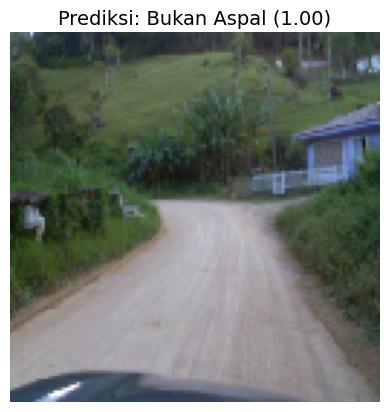

In [13]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Ganti dengan path gambar uji
img_path = 'dataset_split/val/non_aspal/unpavedRegular000000166.png'

img = image.load_img(img_path, target_size=(128, 128))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

pred = model.predict(img_array)[0][0]

# 💬 Tentukan label berdasarkan skor
label_text = "Aspal" if pred < 0.5 else "Bukan Aspal"

plt.imshow(img)
plt.axis('off')
plt.title(f"Prediksi: {label_text} ({pred:.2f})", fontsize=14)
plt.show()